# Load up Data 
We can either use the true validation set which only has 2500 examples, or examine a subset of the training set which has 60000 examples here. 

In [26]:
import numpy as np

USE_VAL = False
NUM_RECORDS = None

IO_FEATURES = ['Perimiter', 'Area', '# Interior Walls', '# Exposed Edges', 
               'Total Markers', 'Max Markers', '# Spots Markers', 
               'Face Change?', 'Displacement_X', 'Displacement_Y', 
               '(D) Total Markers', '(D) Max Markers', '(D) # Spots Markers']

IO_ABBREVS = ['P', 'A', 'IW', 'EE', 'TM', 'MM', 'SM', 'FC', 'DX', 'DY', 'DTM', 'DMM', 'DSM']

if USE_VAL:
    data = np.loadtxt('val-data.csv', delimiter=',').astype(float)
    labels = np.loadtxt('val-labels.csv', delimiter=',')
    NUM_RECORDS = 2500
else:
    data = np.concatenate((np.loadtxt('train-data1.csv', delimiter=','), 
                            np.loadtxt('train-data2.csv', delimiter=','))).astype(float)
    print(data.shape)
    labels = np.loadtxt('train-labels.csv', delimiter=',')[:60000]
    print(labels.shape)
    NUM_RECORDS = 60000

(60000, 96)
(60000,)


In [88]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

def get_nn_accuracy(in_shape, data, labels, val_cutoff):
    model = Sequential()

    model.add(Dense(300, activation='relu', input_shape=(in_shape,)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])
    
    model.fit(data[:val_cutoff], labels[:val_cutoff], 
             batch_size=64, nb_epoch=5, verbose=0)
    _, accuracy = model.evaluate(data[val_cutoff:], labels[val_cutoff:], verbose=0)
    
    return accuracy


# Explore different ways to canonicalize the I/O
 1. Data is coming in as (NUM_RECORDS, 78) -> first reshape to (NUM_RECORDS, 6, 13)
 2. Sort rows based on a column value
 3. reshape back to (NUM_RECORDS, 78)

In [115]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

io_data = data[:, 18:]
reshaped_data = io_data.reshape((NUM_RECORDS, 6, 13))

val_acc = [[] for k in range(13)]
VAL_CUTOFF = int(NUM_RECORDS * 0.8)

for i in range(13):
    for j in range(5):
        fresh_data = np.zeros((NUM_RECORDS, 78))
        for t in range(NUM_RECORDS): # t for trial
            rows = reshaped_data[t]
            sorted_rows = rows[rows[:,i].argsort()]
            fresh_data[t] = sorted_rows.reshape(78)

        reformatted_data = np.concatenate((data[:, :18], fresh_data), axis=1)
        for c in range(96):
            reformatted_data /= np.max(np.abs(reformatted_data[:,c])) + 1e-4
            reformatted_data[:,c] -= np.mean(reformatted_data[:,c])

        log_reg = LogisticRegression()
        log_reg.fit(reformatted_data[:VAL_CUTOFF], labels[:VAL_CUTOFF])
        val_acc[i].append(log_reg.score(reformatted_data[VAL_CUTOFF:], labels[VAL_CUTOFF:]))
    val_acc[i] = sum(val_acc[i]) / 5
    print("Finished feature %s" % i)

Finished feature 0
Finished feature 1
Finished feature 2
Finished feature 3
Finished feature 4
Finished feature 5
Finished feature 6
Finished feature 7
Finished feature 8
Finished feature 9
Finished feature 10
Finished feature 11
Finished feature 12


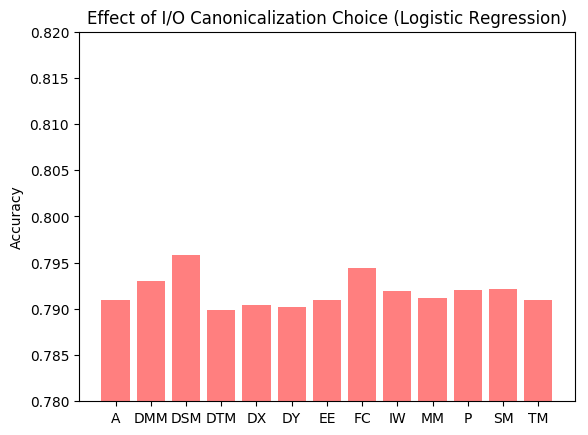

('P', 'Perimiter')
('A', 'Area')
('IW', '# Interior Walls')
('EE', '# Exposed Edges')
('TM', 'Total Markers')
('MM', 'Max Markers')
('SM', '# Spots Markers')
('FC', 'Face Change?')
('DX', 'Displacement_X')
('DY', 'Displacement_Y')
('DTM', '(D) Total Markers')
('DMM', '(D) Max Markers')
('DSM', '(D) # Spots Markers')


In [116]:
x_pos = np.arange(len(IO_ABBREVS))

#print(val_acc)
plt.bar(IO_ABBREVS, val_acc, align='center', alpha=0.5, color='red')
plt.ylim(0.78, 0.82)
plt.ylabel('Accuracy')
plt.title('Effect of I/O Canonicalization Choice (Logistic Regression)')
 
plt.show()
for pair in zip(IO_ABBREVS, IO_FEATURES):
    print(pair)

In [117]:
io_data = data[:, 18:]
reshaped_data = io_data.reshape((NUM_RECORDS, 6, 13))

val_accuracy = [[] for k in range(13)]

for i in range(13):
    for j in range(5):
        fresh_data = np.zeros((NUM_RECORDS, 78))
        for t in range(NUM_RECORDS): # t for trial
            rows = reshaped_data[t]
            sorted_rows = rows[rows[:,i].argsort()]
            fresh_data[t] = sorted_rows.reshape(78)

        reformatted_data = np.concatenate((data[:, :18], fresh_data), axis=1)
        for c in range(96):
            reformatted_data /= np.max(np.abs(reformatted_data[:,c])) + 1e-4
            reformatted_data[:,c] -= np.mean(reformatted_data[:,c])

        accuracy = get_nn_accuracy(96, reformatted_data, labels, VAL_CUTOFF)
        val_accuracy[i].append(accuracy)
    val_accuracy[i] = sum(val_accuracy[i]) / 5
    print("Finished feature %s" % i)


Finished feature 0
Finished feature 1
Finished feature 2
Finished feature 3
Finished feature 4
Finished feature 5
Finished feature 6
Finished feature 7
Finished feature 8
Finished feature 9
Finished feature 10
Finished feature 11
Finished feature 12


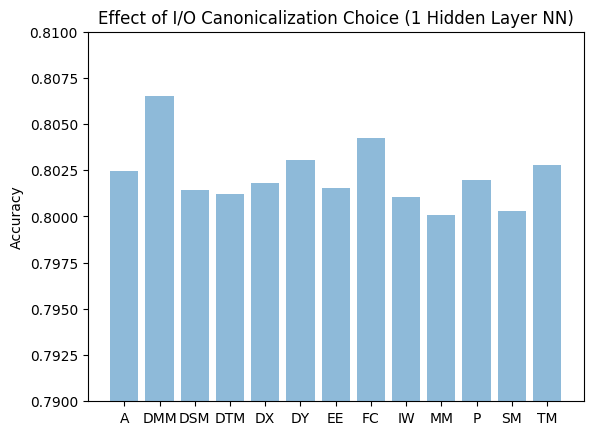

('P', 'Perimiter')
('A', 'Area')
('IW', '# Interior Walls')
('EE', '# Exposed Edges')
('TM', 'Total Markers')
('MM', 'Max Markers')
('SM', '# Spots Markers')
('FC', 'Face Change?')
('DX', 'Displacement_X')
('DY', 'Displacement_Y')
('DTM', '(D) Total Markers')
('DMM', '(D) Max Markers')
('DSM', '(D) # Spots Markers')


In [121]:
x_pos = np.arange(len(IO_ABBREVS))

plt.bar(IO_ABBREVS, val_accuracy, align='center', alpha=0.5)
plt.ylim(0.79, 0.81)
plt.ylabel('Accuracy')
plt.title('Effect of I/O Canonicalization Choice (1 Hidden Layer NN)')
 
plt.show()
for pair in zip(IO_ABBREVS, IO_FEATURES):
    print(pair)

# Explore Relative Importance of Code Features
1. Choose to exclude particular features of code
2. Train Model using features
3. Compare Accuracies

In [122]:
from collections import OrderedDict
all_features = [i for i in range(18)]
code_features = OrderedDict([
    ('no_length' , all_features[1:]),
    ('no_depth'  , [all_features[0]] + all_features[2:]),
    ('no_marker' , all_features[:3] + all_features[5:]), # put/pick markers
    ('no_cond'   , all_features[:5] + all_features[7:]), # if/else
    ('no_loop'   , all_features[:7] + all_features[9:17]), # while/repeat
    ('no_clear'  , all_features[:9] + all_features[12:]), # front/left/right isClear
    ('no_not'    , all_features[:12] + all_features[13:]), 
    ('no_turn'   , all_features[:13] + all_features[15:]), # turn left/right
    ('no_present', all_features[:15] + [all_features[17]]) # (no)MarkersPresent
])

code_val_acc = [[] for i in range(9)]

for i, (f_set_name, f_set) in enumerate(code_features.items()):
    for j in range(5):
        full_features = f_set + [k for k in range(18, 96)]
        reformatted_data = data[:, full_features]

        accuracy = get_nn_accuracy(len(full_features), reformatted_data, labels, VAL_CUTOFF)
        code_val_acc[i].append(accuracy)
    code_val_acc[i] = sum(code_val_acc[i]) / 5
    print("Finished feature %s" % i)

Finished feature 0
Finished feature 1
Finished feature 2
Finished feature 3
Finished feature 4
Finished feature 5
Finished feature 6
Finished feature 7
Finished feature 8


[0.7851166666666667, 0.7776500000000001, 0.7720499999999999, 0.7787333333333334, 0.78695, 0.7873999999999999, 0.7886333333333333, 0.7878666666666666, 0.79105]


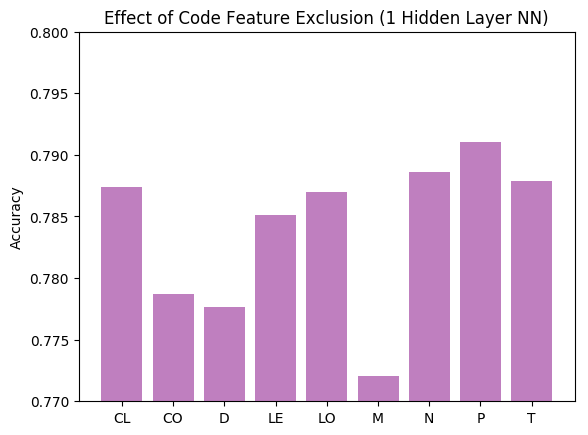

('LE', 'no_length')
('D', 'no_depth')
('M', 'no_marker')
('CO', 'no_cond')
('LO', 'no_loop')
('CL', 'no_clear')
('N', 'no_not')
('T', 'no_turn')
('P', 'no_present')


In [126]:
CODE_ABBREVS = ['LE', 'D', 'M', 'CO', 'LO', 'CL', 'N', 'T', 'P']
x_pos = np.arange(len(CODE_ABBREVS))

print(code_val_acc)
plt.bar(CODE_ABBREVS, code_val_acc, align='center', alpha=0.5, color='purple')
plt.ylim(0.77, 0.80)
plt.ylabel('Accuracy')
plt.title('Effect of Code Feature Exclusion (1 Hidden Layer NN)')
 
plt.show()
for i, (key, val) in enumerate(code_features.items()): 
    print((CODE_ABBREVS[i], key))

# Explore Similarity of Validation to Training Data 
Assign a score to each validation point which characterizes how similar is it to points in the training set. Use this new feature to aid determination of whether the model got the validation data point correct. 

In [100]:
VAL_RECORDS = 2500
VAL_CUTOFF = int(0.8 * VAL_RECORDS)
sim_scores = np.zeros(VAL_RECORDS)

val_data = np.loadtxt('val-data.csv', delimiter=',').astype(float)
val_labels = np.loadtxt('val-labels.csv', delimiter=',')

code_only_train = data[:, :18]
code_only_val = val_data[:, :18]
for i in range(VAL_RECORDS):
    adjusted = code_only_train.copy() 
    adjusted = np.abs(adjusted - code_only_val[i])
    sim_scores[i] = np.sum(adjusted) / 60000

sim_scores = sim_scores.reshape((2500, 1))
val_data = np.concatenate((sim_scores, val_data), axis=1)
#print(val_data.shape)

sim_accuracies = []
no_sim_accuracies = []
for i in range(5):  
    sim_accuracies.append(get_nn_accuracy(97, val_data, val_labels, VAL_CUTOFF))
    no_sim_accuracies.append(get_nn_accuracy(96, val_data[:, 1:], val_labels, VAL_CUTOFF))

sim_accuracy = sum(sim_accuracies) / 5
no_sim_accuracy = sum(no_sim_accuracies) / 5

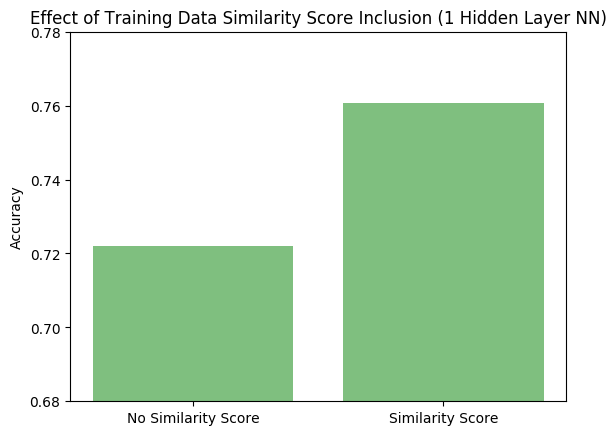

In [101]:
BAR_NAMES = ['Similarity Score', 'No Similarity Score']
scores = [sim_accuracy, no_sim_accuracy]
x_pos = np.arange(len(BAR_NAMES))

#print(val_accuracy)
plt.bar(BAR_NAMES, scores, align='center', alpha=0.5, color='green')
plt.ylim(0.68, 0.78)
plt.ylabel('Accuracy')
plt.title('Effect of Training Data Similarity Score Inclusion (1 Hidden Layer NN)')
 
plt.show()
